<a href="https://colab.research.google.com/github/Blackan06/Build-a-Customer-Churn-Prediction-Model-Using-Decision-Trees/blob/main/Build_a_Customer_Churn_Prediction_Model_Using_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from scipy.stats import chi2_contingency


#Load the Dataset Customer Churn

In [2]:
file_path = '/content/Customer_Data.csv'
data = pd.read_csv(file_path)
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6418 entries, 0 to 6417
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_ID                  6418 non-null   object 
 1   Gender                       6418 non-null   object 
 2   Age                          6418 non-null   int64  
 3   Married                      6418 non-null   object 
 4   State                        6418 non-null   object 
 5   Number_of_Referrals          6418 non-null   int64  
 6   Tenure_in_Months             6418 non-null   int64  
 7   Value_Deal                   2870 non-null   object 
 8   Phone_Service                6418 non-null   object 
 9   Multiple_Lines               5796 non-null   object 
 10  Internet_Service             6418 non-null   object 
 11  Internet_Type                5028 non-null   object 
 12  Online_Security              5028 non-null   object 
 13  Online_Backup     

#Handle missing values


In [3]:
data = data.drop(columns=['Churn_Reason', 'Churn_Category', 'Customer_ID'])


categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].mode()[0], inplace=True)

# Với các cột dạng số, chúng ta sẽ điền bằng giá trị trung vị (median)
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_columns:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)


<ipython-input-3-0efe8912ecc6>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)


#One-Hot Encoding

In [4]:
data.head(10)

,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status
0,Male,35,No,Delhi,7,27,Deal 2,Yes,No,Yes,...,One Year,Yes,Credit Card,65.60,593.30,0.00,0,381.51,974.81,Stayed
1,Female,45,Yes,Maharashtra,14,13,Deal 2,Yes,Yes,Yes,...,Month-to-Month,No,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,Stayed
2,Male,51,No,West Bengal,4,35,Deal 5,Yes,No,Yes,...,Month-to-Month,Yes,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,Churned
3,Male,79,No,Karnataka,3,21,Deal 4,Yes,No,Yes,...,Month-to-Month,Yes,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,Churned
4,Female,80,No,Tamil Nadu,3,8,Deal 2,Yes,No,Yes,...,Month-to-Month,Yes,Credit Card,83.90,267.40,0.00,0,22.14,289.54,Churned
5,Male,24,No,Telangana,9,2,Deal 5,Yes,No,Yes,...,Month-to-Month,Yes,Credit Card,69.40,571.45,0.00,0,150.93,722.38,Stayed
6,Female,66,Yes,Maharashtra,9,23,Deal 1,Yes,No,Yes,...,Two Year,Yes,Bank Withdrawal,109.70,7904.25,0.00,0,707.16,8611.41,Stayed
7,Male,51,Yes,Gujarat,12,24,Deal 2,Yes,Yes,Yes,...,Two Year,Yes,Credit Card,84.65,5377.80,0.00,20,816.48,6214.28,Stayed
8,Female,63,No,Gujarat,4,10,Deal 5,Yes,No,Yes,...,Two Year,Yes,Bank Withdrawal,48.20,340.35,0.00,0,73.71,414.06,Stayed
9,Female,41,No,Uttar Pradesh,3,1,Deal 2,Yes,Yes,Yes,...,Two Year,Yes,Credit Card,90.45,5957.90,0.00,0,1849.90,7807.80,Stayed


In [5]:
columns_to_encode = [
    'State', 'Value_Deal', 'Multiple_Lines','Phone_Service','Gender','Married','Unlimited_Data',
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup',
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies',
    'Streaming_Music', 'Contract', 'Paperless_Billing',
    'Payment_Method'
]

# Filter columns_to_encode to include only those present in the data_cleaned dataframe
columns_to_encode = [col for col in columns_to_encode if col in data.columns]

# Label encode specified categorical features
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

In [6]:
data.head(10)

,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status
0,1,35,0,4,7,27,1,1,0,1,...,1,1,1,65.60,593.30,0.00,0,381.51,974.81,Stayed
1,0,45,1,12,14,13,1,1,1,1,...,0,0,1,-4.00,542.40,38.33,10,96.21,610.28,Stayed
2,1,51,0,21,4,35,4,1,0,1,...,0,1,0,73.90,280.85,0.00,0,134.60,415.45,Churned
3,1,79,0,9,3,21,3,1,0,1,...,0,1,0,98.00,1237.85,0.00,0,361.66,1599.51,Churned
4,0,80,0,17,3,8,1,1,0,1,...,0,1,1,83.90,267.40,0.00,0,22.14,289.54,Churned
5,1,24,0,18,9,2,4,1,0,1,...,0,1,1,69.40,571.45,0.00,0,150.93,722.38,Stayed
6,0,66,1,12,9,23,0,1,0,1,...,2,1,0,109.70,7904.25,0.00,0,707.16,8611.41,Stayed
7,1,51,1,5,12,24,1,1,1,1,...,2,1,1,84.65,5377.80,0.00,20,816.48,6214.28,Stayed
8,0,63,0,5,4,10,4,1,0,1,...,2,1,0,48.20,340.35,0.00,0,73.71,414.06,Stayed
9,0,41,0,19,3,1,1,1,1,1,...,2,1,1,90.45,5957.90,0.00,0,1849.90,7807.80,Stayed


In [7]:
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1, 'Joined':2})

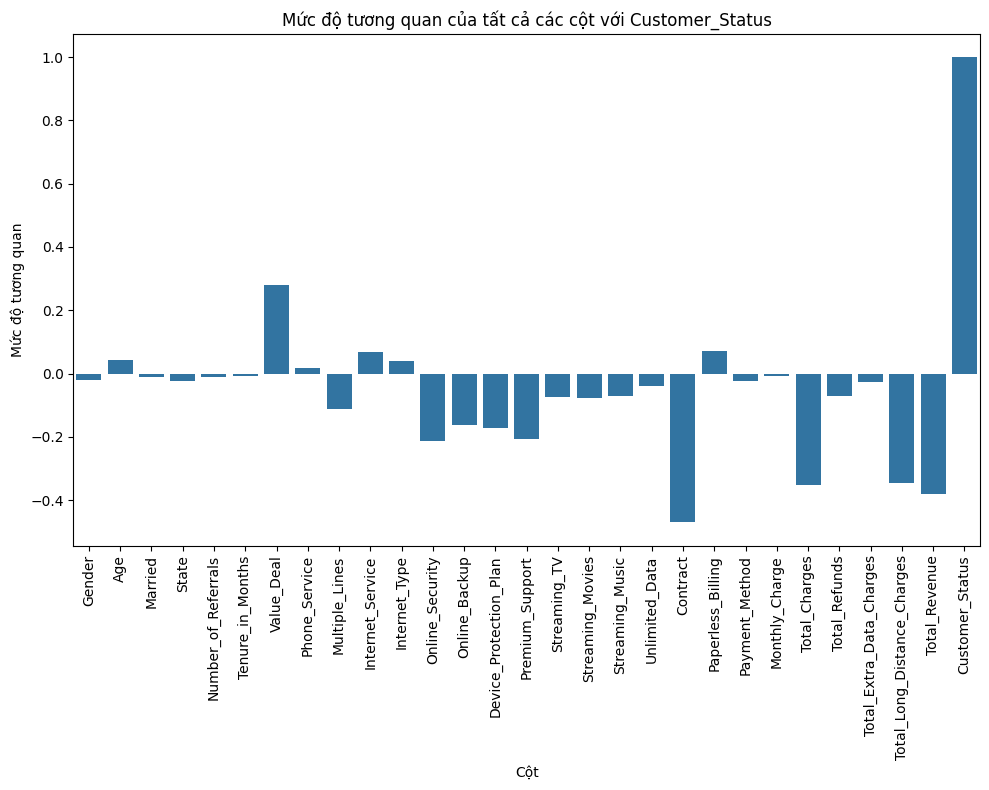

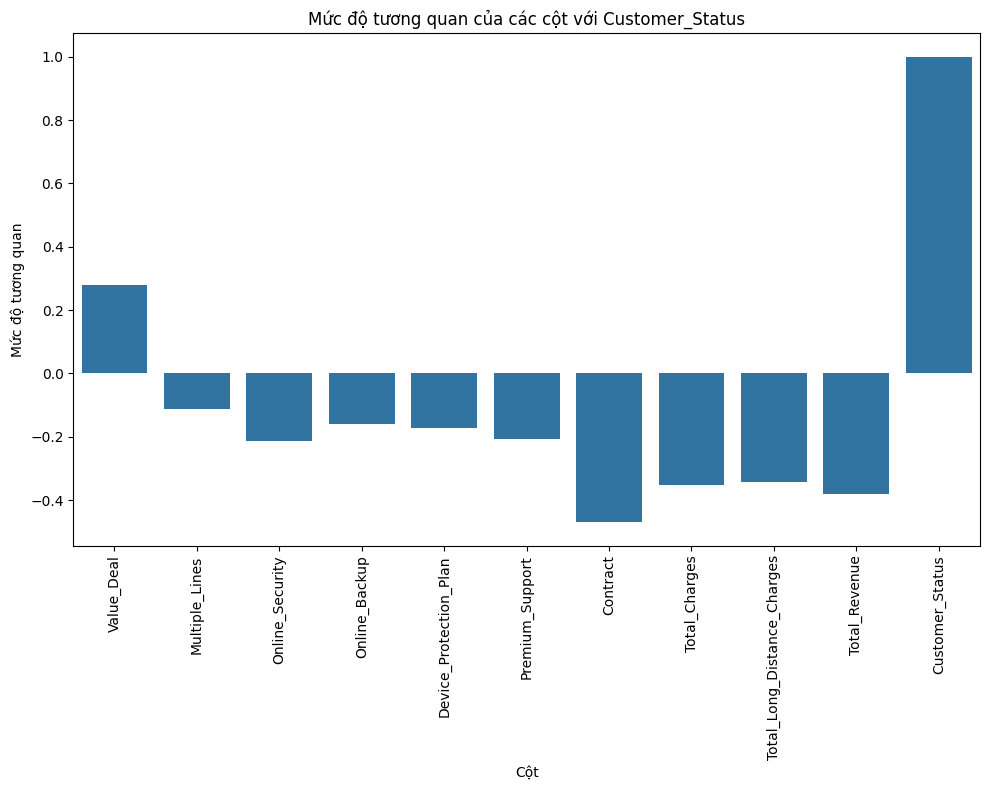

Các cột nên giữ lại: ['Value_Deal', 'Multiple_Lines', 'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Support', 'Contract', 'Total_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue', 'Customer_Status']


In [9]:

numeric_columns = data.select_dtypes(include=['number']).columns

correlations = data[numeric_columns].corr()[
  'Customer_Status'
].dropna()
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=90)
plt.xlabel('Cột')
plt.ylabel('Mức độ tương quan')
plt.title(f'Mức độ tương quan của tất cả các cột với Customer_Status')
plt.tight_layout()
plt.show()
thresh = 0.1
significant_correlations = correlations[correlations.abs() > thresh]

# Vẽ biểu đồ để hiển thị rõ hơn về mức độ tương quan
plt.figure(figsize=(10, 8))
sns.barplot(x=significant_correlations.index, y=significant_correlations.values)
plt.xticks(rotation=90)
plt.xlabel('Cột')
plt.ylabel('Mức độ tương quan')
plt.title(f'Mức độ tương quan của các cột với Customer_Status')
plt.tight_layout()
plt.show()

# Danh sách các cột nên giữ lại
columns_to_keep = significant_correlations.index.tolist()
print("Các cột nên giữ lại:", columns_to_keep)

#Normalizing Numerical Data

In [10]:
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

In [11]:
data.head(10)

,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status
0,1,-0.722698,0,4,-0.092587,0.913163,1,1,0,1,...,1,1,1,0.062435,-0.743902,-0.245264,-0.271782,-0.433212,-0.718374,0
1,0,-0.123979,1,12,1.422185,-0.410643,1,1,1,1,...,0,0,1,-2.169307,-0.766346,4.638490,0.132739,-0.769807,-0.845552,0
2,1,0.235252,0,21,-0.741775,1.669623,4,1,0,1,...,0,1,0,0.328577,-0.881674,-0.245264,-0.271782,-0.724515,-0.913526,1
3,1,1.911665,0,9,-0.958171,0.345817,3,1,0,1,...,0,1,0,1.101350,-0.459693,-0.245264,-0.271782,-0.456631,-0.500426,1
4,0,1.971537,0,17,-0.958171,-0.883431,1,1,0,1,...,0,1,1,0.649230,-0.887605,-0.245264,-0.271782,-0.857194,-0.957454,1
5,1,-1.381288,0,18,0.340205,-1.450777,4,1,0,1,...,0,1,1,0.184283,-0.753536,-0.245264,-0.271782,-0.705249,-0.806443,0
6,0,1.133330,1,12,0.340205,0.534932,0,1,0,1,...,2,1,0,1.476514,2.479801,-0.245264,-0.271782,-0.049013,1.945914,0
7,1,0.235252,1,5,0.989393,0.629490,1,1,1,1,...,2,1,1,0.673279,1.365784,-0.245264,0.537260,0.079962,1.109594,0
8,0,0.953715,0,5,-0.741775,-0.694316,4,1,0,1,...,2,1,0,-0.495500,-0.855438,-0.245264,-0.271782,-0.796352,-0.914011,0
9,0,-0.363467,0,19,-0.958171,-1.545334,1,1,1,1,...,2,1,1,0.859257,1.621574,-0.245264,-0.271782,1.299183,1.665547,0


#Splitting Data into Train, Validation, and Test Sets


In [12]:
# Kiểm tra xem cột 'Customer_Status' ban đầu có giá trị NaN không
print(data['Customer_Status'].isna().sum())


0


In [13]:
train_vali_set = data[data["Customer_Status"] != 2]
test_set = data[data["Customer_Status"] == 2]

train_vali_set.head()

,Gender,Age,Married,State,Number_of_Referrals,Tenure_in_Months,Value_Deal,Phone_Service,Multiple_Lines,Internet_Service,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charge,Total_Charges,Total_Refunds,Total_Extra_Data_Charges,Total_Long_Distance_Charges,Total_Revenue,Customer_Status
0,1,-0.722698,0,4,-0.092587,0.913163,1,1,0,1,...,1,1,1,0.062435,-0.743902,-0.245264,-0.271782,-0.433212,-0.718374,0
1,0,-0.123979,1,12,1.422185,-0.410643,1,1,1,1,...,0,0,1,-2.169307,-0.766346,4.638490,0.132739,-0.769807,-0.845552,0
2,1,0.235252,0,21,-0.741775,1.669623,4,1,0,1,...,0,1,0,0.328577,-0.881674,-0.245264,-0.271782,-0.724515,-0.913526,1
3,1,1.911665,0,9,-0.958171,0.345817,3,1,0,1,...,0,1,0,1.101350,-0.459693,-0.245264,-0.271782,-0.456631,-0.500426,1
4,0,1.971537,0,17,-0.958171,-0.883431,1,1,0,1,...,0,1,1,0.649230,-0.887605,-0.245264,-0.271782,-0.857194,-0.957454,1


In [14]:
test_set.head()
print(f"Số lượng mẫu trong test_set: {test_set.shape[0]}")


Số lượng mẫu trong test_set: 411


In [ ]:
# Split into train and test sets (80% train, 20% test)
X = train_vali_set.drop(columns=['Customer_Status'])
y = train_vali_set['Customer_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the train set into train and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
rows_with_nan_y = y_train[y_train.isna()]
print("Các hàng trong y_train có giá trị NaN:")
print(rows_with_nan_y)



Các hàng trong y_train có giá trị NaN:
Series([], Name: Customer_Status, dtype: int64)


#Handling Imbalanced Data using SMOTE

In [ ]:
# Tính tỷ lệ mất cân bằng giữa các lớp trong y_train
class_counts = y_train.value_counts()

# Đếm số lượng mẫu của lớp chiếm ưu thế và lớp thiểu số
majority_class_count = class_counts.max()
minority_class_count = class_counts.min()

# Tính tỷ lệ mất cân bằng giữa lớp chiếm ưu thế và lớp thiểu số
imbalance_ratio = majority_class_count / minority_class_count

# In ra tỷ lệ mất cân bằng
print(f"Số lượng mẫu trong mỗi lớp:\n{class_counts}\n")
print(f"Tỷ lệ mất cân bằng giữa lớp chiếm ưu thế và lớp thiểu số: {imbalance_ratio:.2f}")


Số lượng mẫu trong mỗi lớp:
Customer_Status
0    2716
1    1128
Name: count, dtype: int64

Tỷ lệ mất cân bằng giữa lớp chiếm ưu thế và lớp thiểu số: 2.41


In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#Building the Random Forest Classifier Model with Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Best model after hyperparameter tuning
best_rf_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'class_weight': None, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


#Evaluating the Model on Validation Set

In [ ]:
y_val_pred = best_rf_model.predict(X_val)
print("\nValidation Set Metrics:")
print(classification_report(y_val, y_val_pred, target_names=['Stayed', 'Churned']))


Validation Set Metrics:
              precision    recall  f1-score   support

      Stayed       0.88      0.95      0.91       718
     Churned       0.80      0.63      0.70       243

    accuracy                           0.87       961
   macro avg       0.84      0.79      0.81       961
weighted avg       0.86      0.87      0.86       961



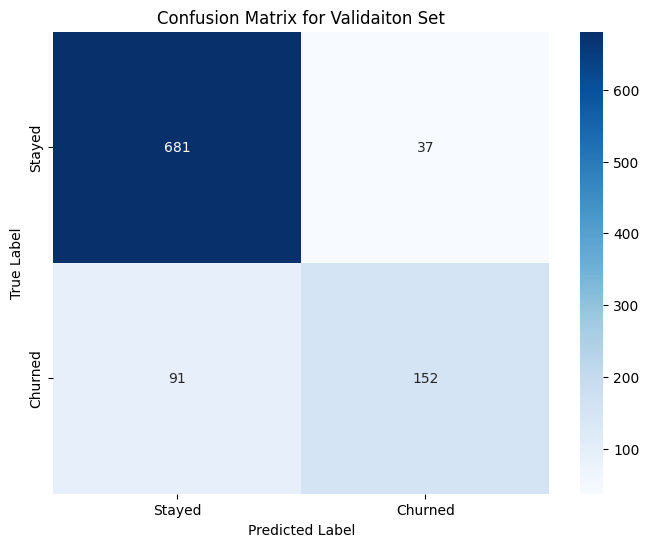

In [ ]:
# Tạo ma trận nhầm lẫn (confusion matrix) cho tập 'Joined'
conf_matrix_joined = confusion_matrix(y_val, y_val_pred)

# Đặt các nhãn cho trục x và y
labels = ['Stayed', 'Churned']

# Vẽ biểu đồ heatmap cho ma trận nhầm lẫn với nhãn đầy đủ và thanh màu
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_joined, annot=True, fmt="d", cmap="Blues", cbar=True, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for Validaiton Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
unique, counts = np.unique(y_val_pred, return_counts=True)
prediction_distribution = dict(zip(unique, counts))
print("Phân phối kết quả dự đoán cho khách hàng")
print(prediction_distribution)


Phân phối kết quả dự đoán cho khách hàng 'Joined':
{0: 772, 1: 189}


# Evaluating the Model on Test Set

In [ ]:
X_test_joined = test_set.drop(columns=['Customer_Status'])
y_test_joined_true = test_set['Customer_Status']  # Nhãn thực tế cho tập 'Joined'

# Dự đoán với mô hình đã huấn luyện
y_test_joined_pred = best_rf_model.predict(X_test_joined)

# Đánh giá mô hình trên tập 'Joined'
print("\nClassification Report for 'Joined' Test Set:")
print(classification_report(y_test_joined_pred, y_test_joined_pred, target_names=['Stayed', 'Churned']))

unique, counts = np.unique(y_test_joined_pred, return_counts=True)
predictions_summary = dict(zip(unique, counts))

print("Thống kê kết quả dự đoán trên tập test:")
label_mapping = {
    0: 'Stayed',
    1: 'Churned'
}

# In kết quả dự đoán với tên nhãn cụ thể
for label, count in predictions_summary.items():
    print(f"{label_mapping[label]}: {count} lần")


Classification Report for 'Joined' Test Set:
              precision    recall  f1-score   support

      Stayed       1.00      1.00      1.00        35
     Churned       1.00      1.00      1.00       376

    accuracy                           1.00       411
   macro avg       1.00      1.00      1.00       411
weighted avg       1.00      1.00      1.00       411

Thống kê kết quả dự đoán trên tập test:
Stayed: 35 lần
Churned: 376 lần


#Plotting the Confusion Matrix for the Test Set

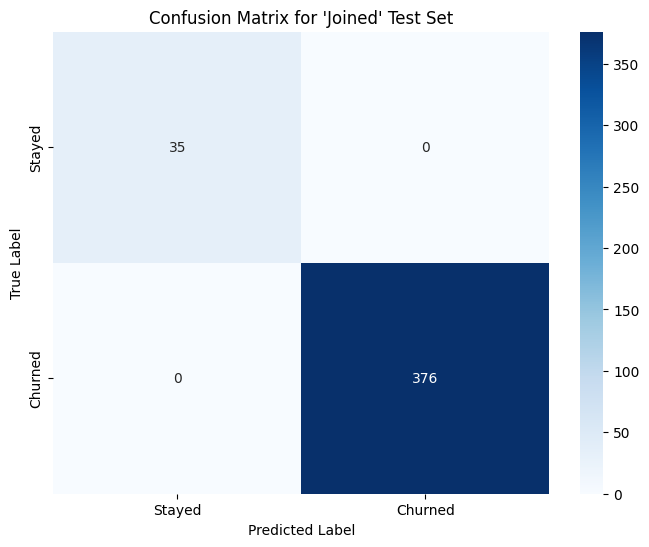

In [ ]:
# Tạo ma trận nhầm lẫn (confusion matrix) cho tập 'Joined'
conf_matrix_joined = confusion_matrix(y_test_joined_pred, y_test_joined_pred)

# Đặt các nhãn cho trục x và y
labels = ['Stayed', 'Churned']

# Vẽ biểu đồ heatmap cho ma trận nhầm lẫn với nhãn đầy đủ và thanh màu
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_joined, annot=True, fmt="d", cmap="Blues", cbar=True, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix for 'Joined' Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Plotting Feature Importances

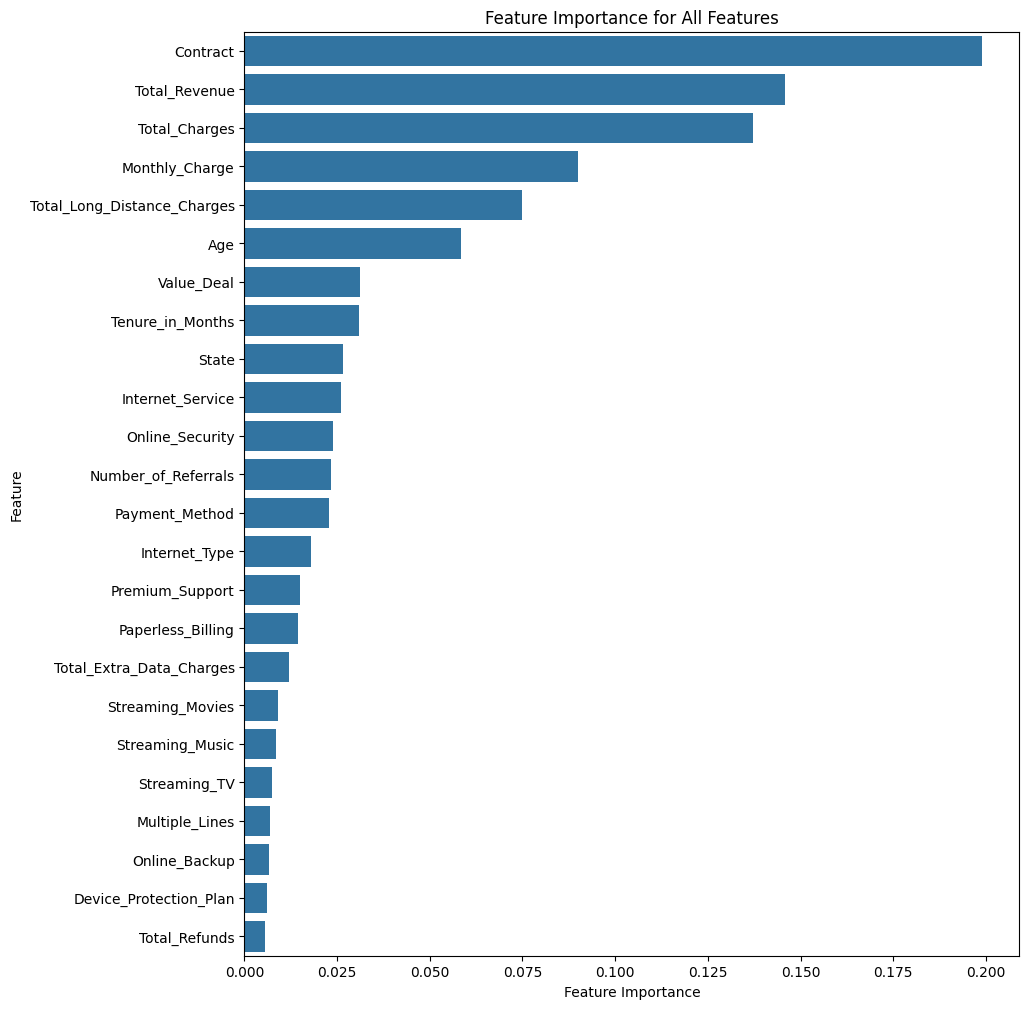

In [ ]:
feature_importances = best_rf_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance for All Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

#Plotting ROC Curve

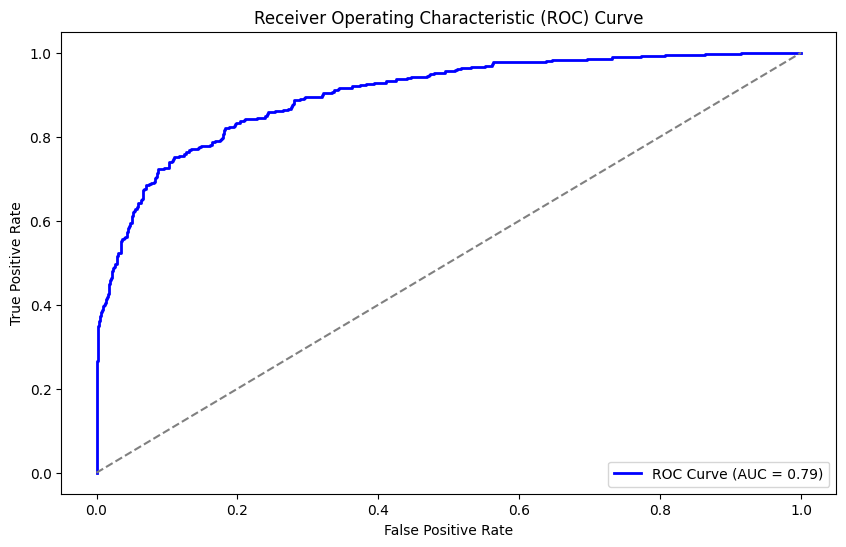

In [ ]:
# Step 12: Plotting ROC Curve
y_test_prob = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
file_path = '/content/Customer_Data.csv'







# Read the data from the specified sheet into a pandas DataFrame

new_data = pd.read_csv(file_path)



# Display the first few rows of the fetched data

print(new_data.head())



# Retain the original DataFrame to preserve unencoded columns

original_data = new_data.copy()



# Retain the Customer_ID column

customer_ids = new_data['Customer_ID']



# Drop columns that won't be used for prediction in the encoded DataFrame

new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason','Unlimited_Data','Gender','Phone_Service','Married'], axis=1)


categorical_columns = new_data.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    if new_data[col].isnull().sum() > 0:
        new_data[col].fillna(new_data[col].mode()[0], inplace=True)

# Với các cột dạng số, chúng ta sẽ điền bằng giá trị trung vị (median)
numerical_columns = new_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in numerical_columns:
    if new_data[col].isnull().sum() > 0:
        new_data[col].fillna(new_data[col].median(), inplace=True)
# Encode categorical variables using the saved label encoders

for column in new_data.select_dtypes(include=['object']).columns:

    new_data[column] = label_encoders[column].transform(new_data[column])



# Make predictions

new_predictions = best_rf_model.predict(new_data)



# Add predictions to the original DataFrame

original_data['Customer_Status_Predicted'] = new_predictions



# Filter the DataFrame to include only records predicted as "Churned"

original_data = original_data[original_data['Customer_Status_Predicted'] == 1]



# Save the results

original_data.to_csv('/content/Customer_Data_Predict.csv', index=False)

  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   19877-DEL    Male   35      No        Delhi                    7   
1   58353-MAH  Female   45     Yes  Maharashtra                   14   
2   25063-WES    Male   51      No  West Bengal                    4   
3   59787-KAR    Male   79      No    Karnataka                    3   
4   28544-TAM  Female   80      No   Tamil Nadu                    3   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                27        NaN           Yes             No  ...   
1                13        NaN           Yes            Yes  ...   
2                35     Deal 5           Yes             No  ...   
3                21     Deal 4           Yes             No  ...   
4                 8        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0      Credit Card           65.6        593.30          0.00   
1      Credit Card          

<ipython-input-185-a56095bad2dd>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data[col].fillna(new_data[col].mode()[0], inplace=True)
